In [1]:
import tensorflow
print(tensorflow.__version__)

2.3.0


In [2]:
import keras
from keras import backend as K

print('Keras version:',keras.__version__)

Keras version: 2.4.3


In [3]:
import pandas as pd
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
# create a pandas dataframe from the csv file we saved of the balanced data set
allclasses = pd.read_csv('/gdrive/My Drive/allclasses', delimiter = ',', index_col=0)
allclasses.head()

,FILE NAME,FORMAT,SIZE,URL,Class
0,Viral Pneumonia (1320).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia
1,Viral Pneumonia (57).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia
2,COVID-19 (150).png,PNG,1024*1024,https://www.sirm.org/2020/03/07/covid-19-caso-12/,COVID-19
3,NORMAL (78).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Normal
4,NORMAL (667).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Normal


In [6]:
# import plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
sns.set()

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.5150 and the standard deviation is 0.2472


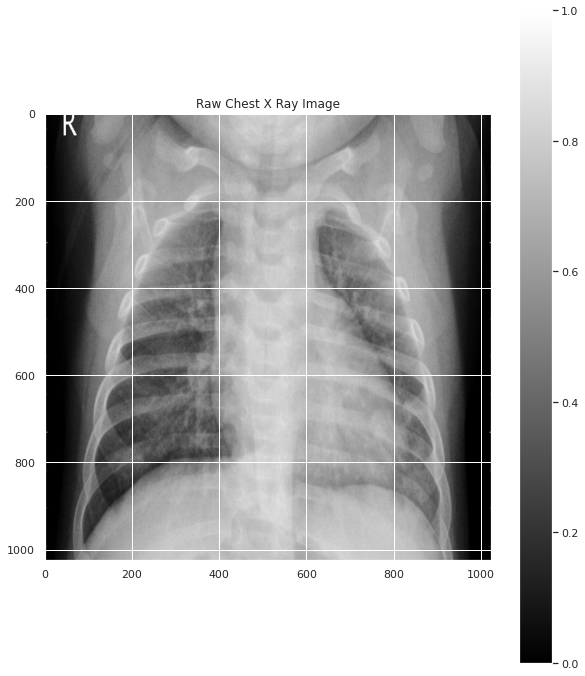

In [7]:
# Get basic statistics from the first image on the dataframe
img_dir = '/gdrive/My Drive/XRays/Viral Pneumonia'
sample_img = allclasses['FILE NAME'][0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.figure(figsize=(10,12))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

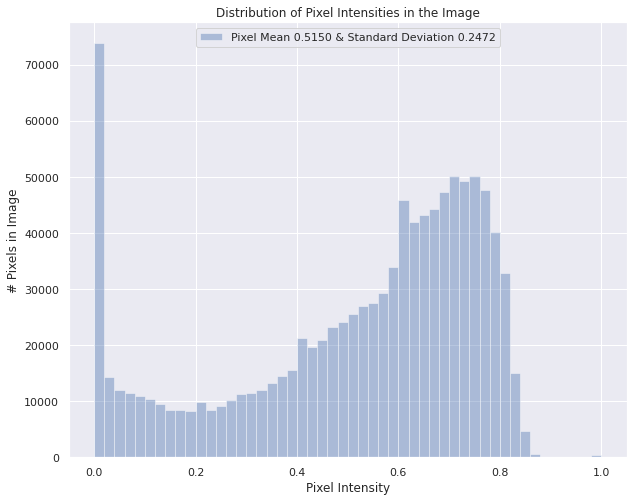

In [8]:
# Plot a histogram of the distribution of the pixels
plt.figure(figsize=(10,8))
sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [9]:
# Import data generator from keras
from keras.preprocessing.image import ImageDataGenerator

In [10]:
# Normalize images
image_generator = ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True # Divide each input by its standard deviation
)

In [11]:
df = allclasses[['FILE NAME','Class']] # just subsetting our dataframe

In [12]:
# Flow from directory with specified batch size and target image size
generator = image_generator.flow_from_dataframe(
        dataframe=df,
        directory='/gdrive/My Drive/XRaysCombo',
        x_col="FILE NAME", # features
        y_col= 'Class', # labels
        class_mode='categorical', # 3 classes
        batch_size= 1, # images per batch
        shuffle=False, # shuffle the rows or not
        #validate_filenames = False, # no validation since we changed the indices
        target_size=(224,224) # width and height of output image this one matches RESNET50
)

Found 571 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 86 invalid image filename(s) in x_col="FILE NAME". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [13]:
# not all images were valid so we're going to subset our data set to only valid images 
# there must be a discrepancy with the rejected images and we should be able to 
# recreate our generator with the subset

allclasses = allclasses[allclasses['FILE NAME'].isin(generator.filenames)]

In [14]:
# Let's check what's missing from before

allclasses['Class'].value_counts()

Normal             219
Viral Pneumonia    219
COVID-19           133
Name: Class, dtype: int64

In [15]:
# of course all the rejected images are Covid, which is our most limited and most 
# important class, so we will need to take a subsample of the other classes
# to rebalance the data set


# We will separate all the classes into individual data sets
covid = allclasses[allclasses['Class']=='COVID-19']
covid.head()

,FILE NAME,FORMAT,SIZE,URL,Class
5,COVID-19 (84).png,PNG,1024*1024,https://www.ncbi.nlm.nih.gov/pubmed/32085849,COVID-19
6,COVID-19 (24).png,PNG,1024*1024,https://academic.oup.com/cid/advance-article/d...,COVID-19
19,COVID-19 (72).png,PNG,1024*1024,https://www.preprints.org/manuscript/202002.01...,COVID-19
27,COVID-19 (10).png,PNG,1024*1024,https://www.sciencedirect.com/science/article/...,COVID-19
31,COVID-19 (29).png,PNG,1024*1024,https://radiopaedia.org/cases/covid-19-pneumon...,COVID-19


In [16]:
normal = allclasses[allclasses['Class']=='Normal']
normal.head()

,FILE NAME,FORMAT,SIZE,URL,Class
3,NORMAL (78).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Normal
4,NORMAL (667).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Normal
7,NORMAL (1151).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Normal
10,NORMAL (241).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Normal
13,NORMAL (219).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Normal


In [17]:
# Take a sample of the normal and pneumonia datasets for which the fractions match the 
# number of covid samples

normal_new = 133/219
normal = normal.sample(frac=normal_new).reset_index(drop=True)
normal.shape[0]

133

In [18]:
pneumonia = allclasses[allclasses['Class']=='Viral Pneumonia']
pneumonia.head()

,FILE NAME,FORMAT,SIZE,URL,Class
0,Viral Pneumonia (1320).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia
1,Viral Pneumonia (57).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia
8,Viral Pneumonia (150).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia
11,Viral Pneumonia (308).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia
12,Viral Pneumonia (1111).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia


In [19]:
pneumonia_new = 133/219
pneumonia = pneumonia.sample(frac=normal_new).reset_index(drop=True)
pneumonia.shape[0]

133

In [20]:
# combine the balanced datasets

noncovid = pd.concat([covid, normal]).reset_index(drop=True)
noncovid.head()

,FILE NAME,FORMAT,SIZE,URL,Class
0,COVID-19 (84).png,PNG,1024*1024,https://www.ncbi.nlm.nih.gov/pubmed/32085849,COVID-19
1,COVID-19 (24).png,PNG,1024*1024,https://academic.oup.com/cid/advance-article/d...,COVID-19
2,COVID-19 (72).png,PNG,1024*1024,https://www.preprints.org/manuscript/202002.01...,COVID-19
3,COVID-19 (10).png,PNG,1024*1024,https://www.sciencedirect.com/science/article/...,COVID-19
4,COVID-19 (29).png,PNG,1024*1024,https://radiopaedia.org/cases/covid-19-pneumon...,COVID-19


In [21]:
allclasses = pd.concat([noncovid, pneumonia]).reset_index(drop=True)
allclasses.head()

,FILE NAME,FORMAT,SIZE,URL,Class
0,COVID-19 (84).png,PNG,1024*1024,https://www.ncbi.nlm.nih.gov/pubmed/32085849,COVID-19
1,COVID-19 (24).png,PNG,1024*1024,https://academic.oup.com/cid/advance-article/d...,COVID-19
2,COVID-19 (72).png,PNG,1024*1024,https://www.preprints.org/manuscript/202002.01...,COVID-19
3,COVID-19 (10).png,PNG,1024*1024,https://www.sciencedirect.com/science/article/...,COVID-19
4,COVID-19 (29).png,PNG,1024*1024,https://radiopaedia.org/cases/covid-19-pneumon...,COVID-19


In [22]:
# take a random sample of the balanced data set to randomize the entries again
allclasses = allclasses.sample(frac=1).reset_index(drop=True)
allclasses.head()

,FILE NAME,FORMAT,SIZE,URL,Class
0,Viral Pneumonia (375).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia
1,COVID-19 (24).png,PNG,1024*1024,https://academic.oup.com/cid/advance-article/d...,COVID-19
2,COVID-19 (17).png,PNG,1024*1024,https://onlinelibrary.wiley.com/doi/full/10.11...,COVID-19
3,NORMAL (53).png,PNG,1024*1024,https://www.kaggle.com/paultimothymooney/chest...,Normal
4,COVID-19 (115).png,PNG,1024*1024,https://www.sciencedirect.com/science/article/...,COVID-19


The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.6278 and the standard deviation is 0.1768


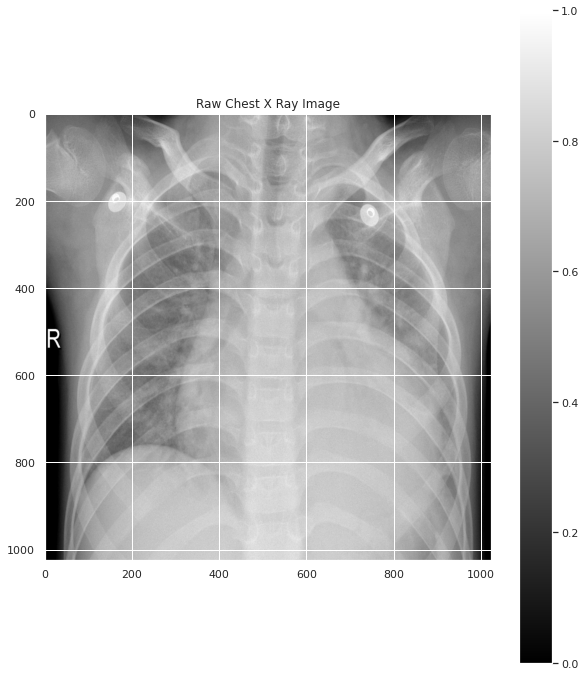

In [23]:
# We will redo these steps with the balanced dataset and hopefully everything 
# works out.
# Get basic statistics from the first image on the dataframe
img_dir = '/gdrive/My Drive/XRaysCombo'
sample_img = allclasses['FILE NAME'][0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.figure(figsize=(10,12))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

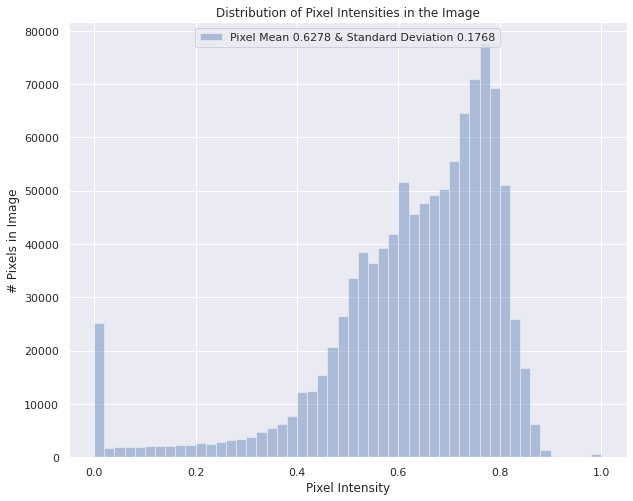

In [24]:
# Plot a histogram of the distribution of the pixels
plt.figure(figsize=(10,8))
sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [25]:
# Flow from directory with specified batch size and target image size
# Recall that the image generator will normalize the data
generator = image_generator.flow_from_dataframe(
        dataframe=allclasses,
        directory='/gdrive/My Drive/XRaysCombo',
        x_col="FILE NAME", # features
        y_col= 'Class', # labels
        class_mode='categorical', # 3 classes
        batch_size= 1, # images per batch
        shuffle=False, # shuffle the rows or not
        #validate_filenames = False, # no validation since we changed the indices
        target_size=(224,224) # width and height of output image this one matches RESNET50
)

Found 399 validated image filenames belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 224 pixels width and 224 pixels height
The maximum pixel value is 2.1088 and the minimum is -3.5569
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


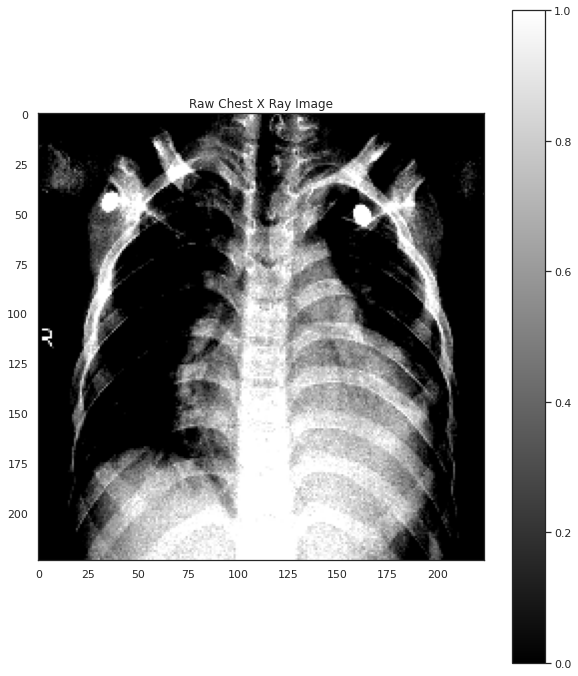

In [26]:
# success! All three classes were validated this time so we'll go ahead and plot the normalized
# image

# Plot a processed image
plt.figure(figsize=(10,12))
sns.set_style("white")
generated_image, label = generator.__getitem__(0)
plt.imshow(np.squeeze(generated_image[0]), cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

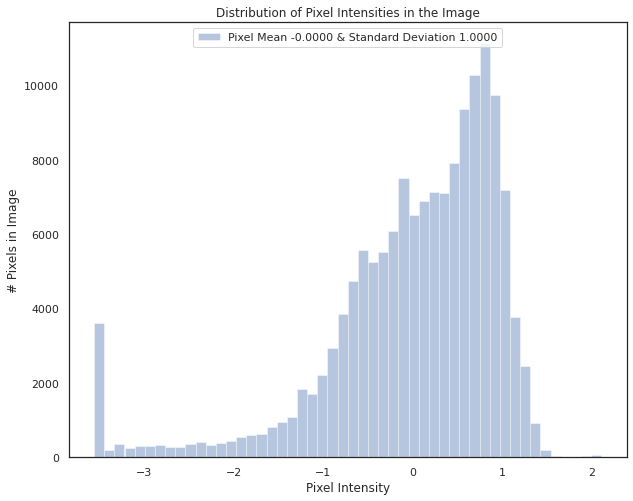

In [27]:
# Plot a histogram of the normalized distribution of the pixels
plt.figure(figsize=(10,8))
sns.distplot(generated_image.ravel(), 
             label=f'Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

I did not note a big difference in the distributions if anything they look pretty much the same, but we did center the mean and now the standard deviation is equal to one. Also note the color saturation in the image above. This should make it easier for our network to learn.

In [28]:
# save data for later use
allclasses = allclasses.to_csv('/gdrive/My Drive/allclasses', header=True)
